In [1]:
# --- Célula 1: Importações ---
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys

# --- ADICIONADO: Imports para Deep Learning com TensorFlow/Keras ---
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
# -----------------------------------------------------------------

# Ferramentas de Pré-processamento e Modelagem
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

# Métricas de Avaliação
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

2025-10-14 21:06:27.288158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-14 21:06:27.304852: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-14 21:06:27.309806: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-14 21:06:27.322712: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-14 21:06:28.079847: W tensorflow/compiler/tf2

In [2]:
# --- Célula 2: Carregamento dos Dados Mestres ---

# Carrega a tabela de modelagem COMPLETA (com todos os anos)
path_final_table = '../data/processed/modeling_table_final.parquet' 
df_completo = pd.read_parquet(path_final_table)

print(f"Tabela de modelagem mestra carregada com {df_completo.shape[0]} dias e {df_completo.shape[1]} colunas.")
print(f"Período total dos dados: de {df_completo.index.min().date()} a {df_completo.index.max().date()}.")

Tabela de modelagem mestra carregada com 5693 dias e 29 colunas.
Período total dos dados: de 2010-02-10 a 2025-09-11.


In [3]:
# --- Célula 3: Definição dos Grupos de Features ---

features_carga = ['programada', 'verificada', 'diferenca_verif_prog']
features_geracao = ['geracao_total_diaria_go', 'geracao_fotovoltaica_diaria', 'geracao_hidroelétrica_diaria', 'geracao_térmica_diaria']
features_rede = ['total_mwh_restrito_go', 'saldo_intercambio_seco']
features_hidrica = ['ear_percentual_seco', 'ena_percentual_mlt_seco']
features_adicionais = ['cmo_semanal_seco', 'disponibilidade_total_diaria_go']
features_clima = ['ghi', 'temp2m_c', 'precipitacao_mm']
features_avancadas = ['carga_media_7d', 'carga_std_7d', 'geracao_media_7d', 'ear_ontem', 'ear_diff_3d', 'margem_oferta_demanda', 'pressao_demanda_ear', 'precip_acumulada_14d', 'precip_acumulada_30d']
features_calendario = ['mes', 'dia_da_semana', 'dia_do_ano']

print("Grupos de features definidos com sucesso.")

Grupos de features definidos com sucesso.


In [4]:
# --- Célula 4: Painel de Controle do Experimento (LSTM) ---
import sys

# Adiciona a pasta raiz ao path para encontrar o config.py
sys.path.append('..') 
from config import END_YEAR

# --- ESCOLHA O CENÁRIO PARA TESTAR ---
# Opções: 'pos_2022', 'pos_2020', 'pos_2017', 'pos_2015', 'pos_2013', 'pos_2010'
# Para LSTMs, cenários com mais dados históricos (ex: pos_2020 ou mais antigos) costumam ser melhores.
CENARIO_ESCOLHIDO = 'pos_2017' 
# -------------------------------------

# Define o período de análise e as features com base no cenário escolhido
if CENARIO_ESCOLHIDO == 'pos_2022':
    START_YEAR = 2022
    nome_cenario = "LSTM Pós-2022 (Features de Geração)"
    features_para_teste_nomes = (
        features_geracao + features_rede + features_hidrica +
        features_adicionais + features_clima + features_calendario +
        features_avancadas + ['programada'] 
    )
elif CENARIO_ESCOLHIDO == 'pos_2020':
    START_YEAR = 2020
    nome_cenario = "LSTM Pós-2020 (Histórico com Carga Prog.)"
    features_para_teste_nomes = (
        features_hidrica + features_adicionais + features_clima +
        features_calendario + features_avancadas + ['programada']
    )
elif CENARIO_ESCOLHIDO == 'pos_2017':
    START_YEAR = 2017
    nome_cenario = "LSTM Pós-2017 (Histórico Intermediário)"
    features_para_teste_nomes = (
        features_hidrica + features_adicionais + features_clima +
        features_calendario + features_avancadas
    )
elif CENARIO_ESCOLHIDO == 'pos_2015':
    START_YEAR = 2015
    nome_cenario = "LSTM Pós-2015 (Histórico com Disponibilidade)"
    features_para_teste_nomes = (
        features_hidrica + features_adicionais + features_clima +
        features_calendario + features_avancadas
    )
elif CENARIO_ESCOLHIDO == 'pos_2013':
    START_YEAR = 2013
    nome_cenario = "LSTM Pós-2013 (Histórico Extendido Básico)"
    features_para_teste_nomes = (
        features_hidrica + features_clima + features_calendario + 
        features_avancadas + ['cmo_semanal_seco']
    )
elif CENARIO_ESCOLHIDO == 'pos_2010':
    START_YEAR = 2010
    nome_cenario = "LSTM Pós-2010 (Máximo Histórico Básico)"
    features_para_teste_nomes = (
        features_hidrica + features_clima + features_calendario + 
        features_avancadas + ['cmo_semanal_seco']
    )
else:
    raise ValueError("Cenário escolhido é inválido.")

print(f"--- INICIANDO EXPERIMENTO COM O CENÁRIO: '{nome_cenario}' ---")
print(f"Período de análise: de {START_YEAR} a {END_YEAR}")

# --- FILTRAGEM E SELEÇÃO DE DADOS ---
# Filtra a tabela mestra para o período do experimento
anos_de_interesse = range(START_YEAR, END_YEAR + 1)
df = df_completo[df_completo.index.year.isin(anos_de_interesse)].copy()
print(f"-> Tabela filtrada por data, resultando em {df.shape[0]} dias para modelagem.")

# Seleciona apenas as colunas válidas para o cenário
features_para_teste = [col for col in features_para_teste_nomes if col in df.columns]
X = df[features_para_teste]
y = df['nivel_risco']

print(f"Número de features selecionadas para este cenário: {len(X.columns)}")
print("\nAmostragem de classes no dataset deste cenário:")
print(y.value_counts())

--- INICIANDO EXPERIMENTO COM O CENÁRIO: 'LSTM Pós-2017 (Histórico Intermediário)' ---
Período de análise: de 2017 a 2025
-> Tabela filtrada por data, resultando em 3176 dias para modelagem.
Número de features selecionadas para este cenário: 16

Amostragem de classes no dataset deste cenário:
nivel_risco
baixo    3134
medio      32
alto       10
Name: count, dtype: int64


In [5]:
# --- Célula 5: Preparação dos Dados para LSTM ---

# 1. Mapeamento e Separação de Treino/Teste
mapeamento_risco = {'baixo': 0, 'medio': 1, 'alto': 2}
y_encoded = y.map(mapeamento_risco)

# Separação TREINO + VALIDAÇÃO de TESTE (dados futuros)
# Para séries temporais, NÃO usamos train_test_split aleatório para evitar que o modelo "veja o futuro".
test_size = 0.2
split_index = int(len(X) * (1 - test_size))

X_train_full = X[:split_index]
y_train_full = y_encoded[:split_index]
X_test = X[split_index:]
y_test = y_encoded[split_index:]

# 2. Escalonamento dos dados
scaler = StandardScaler()
X_train_full_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test)

# 3. Função para criar as sequências (janelas de tempo)
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 14 # Usaremos 14 dias de histórico para prever o risco no dia seguinte

# Cria as sequências para treino e teste
X_train_seq, y_train_seq = create_sequences(X_train_full_scaled, y_train_full.values, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, TIME_STEPS)

print("Formato dos dados de treino (amostras, timesteps, features):", X_train_seq.shape)
print("Formato dos dados de teste (amostras, timesteps, features):", X_test_seq.shape)

Formato dos dados de treino (amostras, timesteps, features): (2526, 14, 16)
Formato dos dados de teste (amostras, timesteps, features): (622, 14, 16)


In [6]:
# --- Célula 6 (Versão Adaptada com Oversampling e Ajuste de Objetivo) ---
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import RandomOverSampler

# 0. Oversampling nas sequências de treino
print("Aplicando Oversampling (RandomOverSampler) para balancear as classes...")

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(
    X_train_seq.reshape(X_train_seq.shape[0], -1), y_train_seq
)
X_res = X_res.reshape(-1, X_train_seq.shape[1], X_train_seq.shape[2])

print("Distribuição original das classes no treino:")
print(pd.Series(y_train_seq).value_counts())
print("\nDistribuição após Oversampling:")
print(pd.Series(y_res).value_counts())

# 1. Função para Construção do Modelo
def build_model(hp):
    model = Sequential()
    hp_units_1 = hp.Int('units_1', min_value=32, max_value=128, step=32)
    hp_units_2 = hp.Int('units_2', min_value=16, max_value=64, step=16)
    hp_dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
    hp_dense_units = hp.Int('dense_units', min_value=16, max_value=64, step=16)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.add(LSTM(units=hp_units_1, input_shape=(X_res.shape[1], X_res.shape[2]), return_sequences=True))
    model.add(Dropout(rate=hp_dropout))
    model.add(LSTM(units=hp_units_2))
    model.add(Dropout(rate=hp_dropout))
    model.add(Dense(units=hp_dense_units, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# 2. Configuração do "Tuner" (mudando para otimizar val_accuracy)
tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective("val_accuracy", direction="max"),
    max_trials=10,
    executions_per_trial=2,
    directory='keras_tuner_dir',
    project_name=f'lstm_tuning_{CENARIO_ESCOLHIDO}',
    overwrite=True
)

# 3. Execução da Busca
print(f"\nIniciando a busca de hiperparâmetros para o LSTM no cenário '{nome_cenario}' (com Oversampling)...")

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tuner.search(
    X_res, 
    y_res, 
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

print("\nBusca de hiperparâmetros concluída.")

Trial 10 Complete [00h 02m 55s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 45m 56s

Busca de hiperparâmetros concluída.



--- Melhores Hiperparâmetros Encontrados ---
- units_1: 96
- units_2: 32
- dropout: 0.30000000000000004
- dense_units: 48
- learning_rate: 0.001
-------------------------------------------


/home/paulo/Code/ons-risk-prediction/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 14, 96)         │        43,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 48)             │         1,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,635 (240.76 KB)

 Trainable params: 61,635 (240.76 KB)

 Non-trainable params: 0 (0.00 B)


Obtendo as probabilidades do melhor modelo LSTM nos dados de teste...
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

--- Resultados Finais do Cenário: LSTM Pós-2017 (Histórico Intermediário) (LSTM Otimizado) ---
              precision    recall  f1-score   support

       baixo       0.99      0.98      0.98       615
       medio       0.06      0.20      0.09         5
        alto       0.00      0.00      0.00         2

    accuracy                           0.97       622
   macro avg       0.35      0.39      0.36       622
weighted avg       0.98      0.97      0.97       622



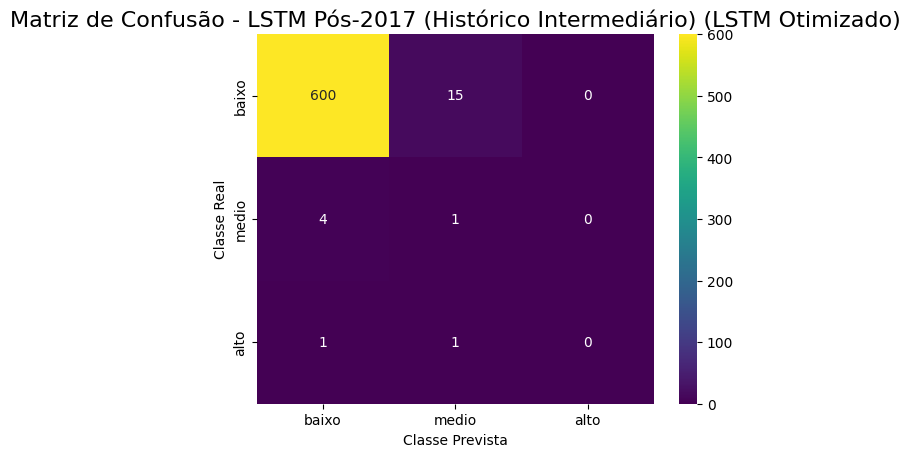


Modelo LSTM salvo com sucesso em: ../models/best_lstm_model_LSTM Pós-2017 (Histórico Intermediário).h5


In [7]:
# --- Célula 7: Obtenção, Avaliação e Salvamento do Modelo LSTM ---
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Obter os melhores hiperparâmetros e o melhor modelo do 'tuner'
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

print("\n--- Melhores Hiperparâmetros Encontrados ---")
for hp in best_hps.values:
    print(f"- {hp}: {best_hps.get(hp)}")
print("-------------------------------------------")

best_model.summary()

# 2. Avaliação final nos dados de teste
print("\nObtendo as probabilidades do melhor modelo LSTM nos dados de teste...")
y_pred_proba = best_model.predict(X_test_seq)

# --- Ajuste os limiares aqui ---
threshold_alto = 0.05
threshold_medio = 0.15
# -----------------------------

y_pred_custom = []
for probs in y_pred_proba:
    prob_baixo, prob_medio, prob_alto = probs
    if prob_alto >= threshold_alto:
        y_pred_custom.append(2)
    elif prob_medio >= threshold_medio:
        y_pred_custom.append(1)
    else:
        y_pred_custom.append(0)

y_pred_custom = np.array(y_pred_custom)

print(f"\n--- Resultados Finais do Cenário: {nome_cenario} (LSTM Otimizado) ---")
print(classification_report(y_test_seq, y_pred_custom, 
                            target_names=mapeamento_risco.keys(), 
                            zero_division=0))

cm_custom = confusion_matrix(y_test_seq, y_pred_custom)
sns.heatmap(cm_custom, annot=True, fmt='d', cmap='viridis', 
            xticklabels=mapeamento_risco.keys(), 
            yticklabels=mapeamento_risco.keys())
plt.title(f'Matriz de Confusão - {nome_cenario} (LSTM Otimizado)', fontsize=16)
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()

# 3. Salvamento do modelo
output_path = f'../models/best_lstm_model_{nome_cenario}.h5'
os.makedirs(os.path.dirname(output_path), exist_ok=True)

best_model.save(output_path)
print(f"\nModelo LSTM salvo com sucesso em: {output_path}")
